# Optimisation de la variance montecarlo par quantification du facteur d'acceleration
Dans ce notebook on  explore et quantifie l'efficacité de la méthode de réduction de variance par Variables Antithétiques (VA) dans le cadre de l'estimation du prix d'un Call Européen par simulation Monte Carlo.

In [ ]:
%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:


# ------------------------------------------------------------------
# Imports des bibliothèques standard 
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Importations nécessaires pour corriger le chemin d'accès
import sys
import os

# ------------------------------------------------------------------
# CORRECTION DU CHEMIN D'ACCÈS POUR LES IMPORTS LOCAUX
# Le Notebook étant dans 'notebooks/', nous ajoutons le répertoire parent (MBG_MONTECARLO)
# au chemin de recherche Python(PYTHONPATH) pour trouver le dossier 'src'.
# ------------------------------------------------------------------

# Obtient le chemin absolu du répertoire de travail actuel
# (Ex: /chemin/vers/MBG_MONTECARLO/notebooks)
current_dir = os.getcwd() 

# Remonte au répertoire parent (Ex: /chemin/vers/MBG_MONTECARLO)
parent_dir = os.path.dirname(current_dir)

# Ajoute le répertoire parent à sys.path. 
# Maintenant, Python sait que 'src' est un sous-dossier valide.
sys.path.append(parent_dir)

# ------------------------------------------------------------------
# IMPORTATIONS DES FONCTIONS SOURCES
# ------------------------------------------------------------------

from src.estimateur_montecarlo import prix_montecarlo_call, vrai_prix_call 

from src.variables_antithétiques import price_mc_antithetic_call



# ------------------------------------------------------------------
# Définition des paramètres fondamentaux de l'option
# ------------------------------------------------------------------
S0 = 100.0   # Prix initial du sous-jacent
K = 100.0    # Prix d'exercice (Strike)
r = 0.05     # Taux sans risque
sigma = 0.2  # Volatilité
T = 1.0      # Temps jusqu'à l'échéance (en années)

#---------------------------------------------------------------
#Parametre de simulation pour la quantification
#---------------------------------------------------------------

N_paths = 50000      # Nombre de PAIRES/REALISATIONS par run (doit être élevé pour assurer la convergence)
N_runs = 200         # Nombre de répétitions pour estimer la variance de l'estimateur (doit être élevé)

#---------------------------------------------------------------
#Parametre pour la génération de nombre aléatoire
#---------------------------------------------------------------

seed = 21



## Quantification du Facteur d'Accélération ($\mathcal{S}$)
Nous exécutons $N_{\text{runs}}$ répétitions pour estimer la variance de chaque estimateur $\text{Var}(\widehat{{C}})$.

### Execution de la quantification

In [35]:
print("\n=======================================================")
print("ANALYSE QUANTITATIVE : CALL EUROPÉEN")
print("=======================================================")
print(f"Comparaison basée sur N_runs = {N_runs} répétitions, avec N = {N_paths} (réalisations/paires) par run.")

results_std = np.zeros(N_runs) # on stocke le prix estimé du call méthode Monte Carlo standard pour chaque run
results_anti = np.zeros(N_runs) # on stocke le prix estimé du call méthode antithétique pour chaque run


for i in range(N_runs):

    seed_i = seed +i # on choisi un seed different pour avoir  des run independants
    # MCS : N_paths réalisations
    results_std[i] =  prix_montecarlo_call(S0, K, r, sigma, T, N_paths, seed=seed_i)[0] # le prix est le 1er element
    
    prix_montecarlo_call(S0, K, r, sigma, T, N_paths, seed=seed_i)[0]
    # VA : N_paths paires (2*N_paths chemins au total)
    results_anti[i] = price_mc_antithetic_call(S0, K, T, r, sigma, N_paths,seed=seed_i) 


# --- Calcul des Statistiques ---

var_std = np.var(results_std, ddof=1)  # ddof=1 pour avoir un estimateur non biaisé
var_anti = np.var(results_anti, ddof=1)

# Facteur d'Accélération : S = Var(C_std) / Var(C_anti)
FA = var_std / var_anti


ANALYSE QUANTITATIVE : CALL EUROPÉEN
Comparaison basée sur N_runs = 200 répétitions, avec N = 50000 (réalisations/paires) par run.


### Resultats tabulaires

In [ ]:
print("\n--- Résultats de la Quantification (Facteur d'Accélération S) ---")
print("\n| Méthode | Prix Moyen Estimé | Variance Empirique (Efficacité) | Écart-Type (Erreur MC) | Facteur S |")
print("| :---: | :---: | :---: | :---: | :---: |")
print(f"| Standard | {np.mean(results_std):.4f} | {var_std:.6e} | {np.sqrt(var_std):.4e} | 1.00 |")
print(f"| Antithétique | {np.mean(results_anti):.4f} | {var_anti:.6e} | {np.sqrt(var_anti):.4e} | {FA:.2f} |")
print("\nConclusion: Pour le Call Européen (payoff monotone), l'estimateur VA réduit la variance d'un facteur S.")


--- Résultats de la Quantification (Facteur d'Accélération S) ---
Temps total de l'analyse : 2.27 secondes.

| Méthode | Prix Moyen Estimé | Variance Empirique (Efficacité) | Écart-Type (Erreur MC) | Facteur S |
| :---: | :---: | :---: | :---: | :---: |
| Standard | 10.4488 | 5.012043e-03 | 7.0796e-02 | 1.00 |
| Antithétique | 10.4511 | 1.442421e-03 | 3.7979e-02 | 3.47 |

Conclusion: Pour le Call Européen (payoff monotone), l'estimateur VA réduit la variance d'un facteur S.


## Visualisation avec un boxplot

### Execution du graphique


In [39]:
def plot_results(results_std, results_anti, C0):
    """Génère un box-plot pour visualiser la réduction de variance."""
    
    data = [results_std, results_anti]
    labels = ['Monte Carlo Standard (MCS)', 'Variables Antithétiques (VA)']
    
    plt.figure(figsize=(10, 6))
    
    # Création du Box-Plot
    plt.boxplot(data, labels=labels, vert=True, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2),
                flierprops=dict(marker='o', markersize=5, linestyle='none', color='gray'))
    
    # Ligne de référence analytique
    plt.axhline(C0, color='darkgreen', linestyle='--', linewidth=1.5, label=f'Prix Théorique BS ({C0:.4f})')
    
    # Titres et étiquettes
    plt.title(f'Comparaison de la Dispersion des Estimateurs MC pour le Call Européen (S={FA:.2f})', fontsize=14)
    plt.ylabel('Prix Estimé', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.legend()
    plt.show()



### Visualisation du graphe

C:\Users\Guy Groguhe\AppData\Local\Temp\ipykernel_3812\3609675284.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True,


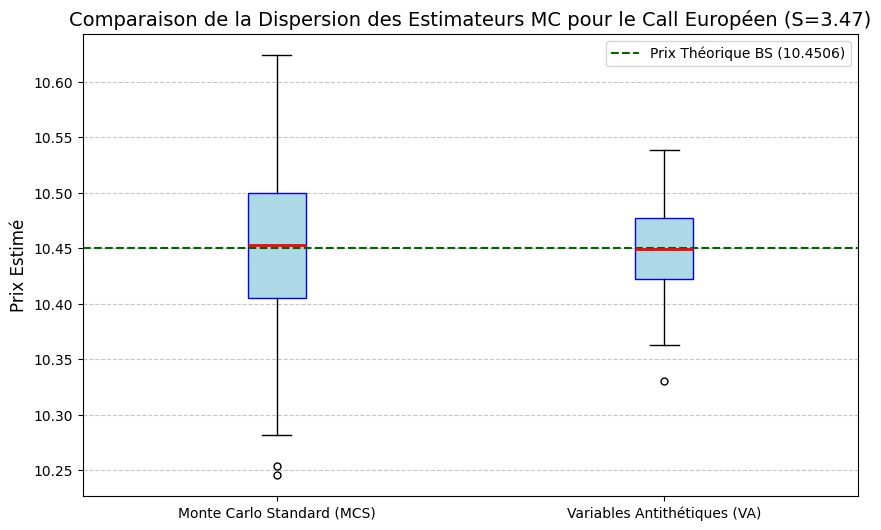

In [41]:
# prix de reference Black Scholes

C_BS = vrai_prix_call(S0, K, r, sigma, T)

# Affichage du Box-Plot
plot_results(results_std, results_anti, C_BS)

# Image visuelle du Box Plot
